# Pulse Sequence Diagnostics (Minimal)

This notebook demonstrates three core checks using the refactored pulse system and public APIs:
- Envelope type comparison (cos^2 vs gaussian)
- Spectral comparison of single-pulse envelopes
- Dynamic modification of phases and delays in a 3-pulse sequence

In [1]:
# Minimal imports for this streamlined notebook
import numpy as np
import matplotlib.pyplot as plt

# Use public APIs only
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qspectro2d.core.laser_system.laser_fcts import pulse_envelopes
from qspectro2d.visualization.plotting import plot_pulse_envelopes

# Helper: summed envelope using module function
def envelopes(times: np.ndarray, seq: LaserPulseSequence) -> np.ndarray:
    return pulse_envelopes(times, seq)


def plot_envelopes(times: np.ndarray, seq: LaserPulseSequence, ax=None, label_prefix: str = "env"):
    fig, ax = plot_pulse_envelopes(times, seq, ax=ax, show_legend=True)
    ax.set_title("Summed pulse envelopes")
    return fig, ax

## 1. Envelope Type Comparison

Section 1: Envelope type comparison (cos^2 vs gaussian)


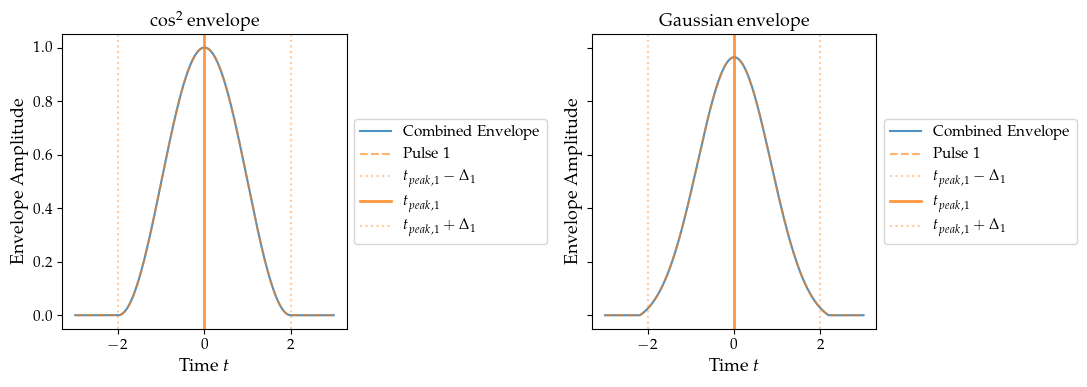

In [5]:
# Envelope Type Comparison using from_pulse_delays
print("Section 1: Envelope type comparison (cos^2 vs gaussian)")

# Parameters
fwhm       = 2.0     # fs (FWHM)
amplitude  = 1.0     # a.u.
carrier_cm = 16000.0 # cm^-1
phase_val  = np.pi/2 # rad

# Build single-pulse sequences via delays (single pulse -> empty delays list)
seq_cos2  = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=amplitude,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=carrier_cm,
    envelope_type="cos2",
    relative_E0s=[1.0],
    phases=[phase_val],
)
seq_gauss = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=amplitude,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=carrier_cm,
    envelope_type="gaussian",
    relative_E0s=[1.0],
    phases=[phase_val],
)

# Manually relocate peak of single pulse to desired t_peak (first pulse defaults to 0 fs)
local_times = np.linspace(- 1.5 * fwhm, + 1.5 * fwhm, 800)

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
plot_envelopes(local_times, seq_cos2, ax=axes[0], label_prefix="cos2")
axes[0].set_title(r"cos$^2$ envelope")
plot_envelopes(local_times, seq_gauss, ax=axes[1], label_prefix="gaussian")
axes[1].set_title(r"Gaussian envelope")
fig.tight_layout()

## 2. Multi-Pulse Gaussian Sequence Diagnostics

Section 2: Multi-pulse gaussian diagnostics (envelope only)
✓ Multi-pulse gaussian diagnostic ready
✓ Multi-pulse gaussian diagnostic ready


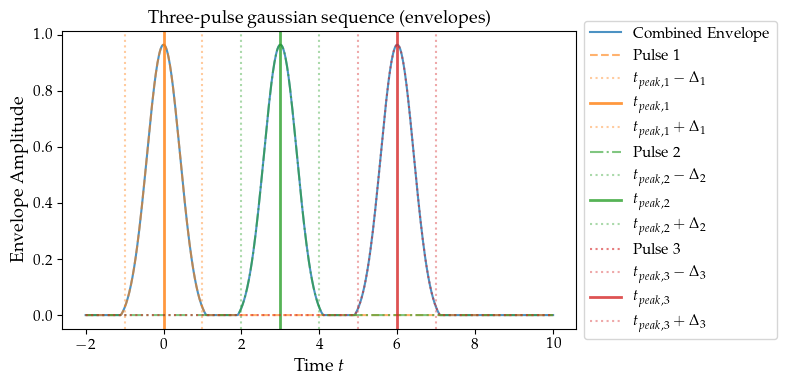

In [3]:
# Multi-Pulse Gaussian Diagnostics (kept minimal)
print("Section 2: Multi-pulse gaussian diagnostics (envelope only)")

times = np.linspace(-2.0, 10.0, 600)

# Build 3-pulse sequence from delays: delays define gaps between consecutive peaks
# Example: peak times at 0.0, 3.0, 6.0 fs -> delays [3.0, 3.0]
seq_multi = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[3.0, 3.0],
    base_amplitude=1.0,
    pulse_fwhm_fs=1.0,
    carrier_freq_cm=10000.0,
    envelope_type="gaussian",
    relative_E0s=[1.0, 1.5, 0.8],
    phases=[0.0, 1.57, 3.14],
)
fig2, ax2 = plt.subplots(figsize=(8, 4))
plot_envelopes(times, seq_multi, ax=ax2, label_prefix="gaussian")
ax2.set_title("Three-pulse gaussian sequence (envelopes)")
fig2.tight_layout()
print("✓ Multi-pulse gaussian diagnostic ready")

## 2. Spectral Envelope Comparison

Section 3: Spectral comparison of envelope shapes
✓ Spectral comparison ready


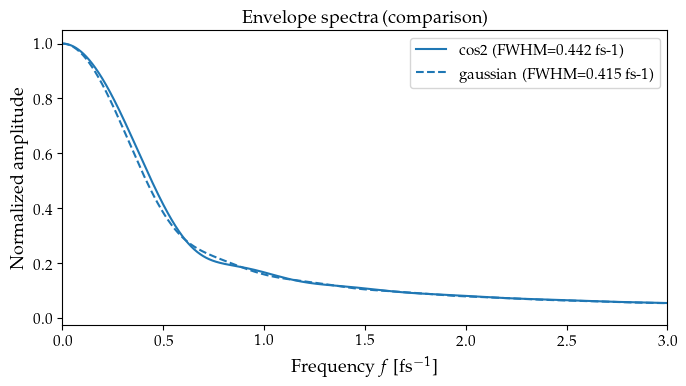

In [8]:
# Spectral comparison (FFT of envelopes)
print("Section 3: Spectral comparison of envelope shapes")

def spectral_envelope(times: np.ndarray, seq: LaserPulseSequence):
    env = envelopes(times, seq)
    N   = len(times)
    dt  = times[1] - times[0]
    N_fft = 1 << (N - 1).bit_length()  # next power of two
    spec = np.fft.fft(env, n=N_fft)
    freq = np.fft.fftfreq(N_fft, dt)
    pos  = freq >= 0
    mag  = np.abs(spec[pos])
    if mag.max() > 0:
        mag = mag / mag.max()
    # FWHM estimate
    idx = np.where(mag >= 0.5)[0]
    fwhm_freq = (freq[pos][idx[-1]] - freq[pos][idx[0]]) if len(idx) > 1 else 0.0
    return freq[pos], mag, fwhm_freq

DT     = 0.05  # fs
T_MAX  = 300.0 # fs
spec_t = np.arange(0.0, T_MAX, DT)

# Build fresh single-pulse sequences at t=0 for spectral analysis
seq_cos2_spec  = LaserPulseSequence.from_pulse_delays([], amplitude, fwhm, carrier_cm, "cos2", [1.0], [phase_val])
seq_gauss_spec = LaserPulseSequence.from_pulse_delays([], amplitude, fwhm, carrier_cm, "gaussian", [1.0], [phase_val])

f_cos, mag_cos, fwhm_cos = spectral_envelope(spec_t, seq_cos2_spec)
f_gau, mag_gau, fwhm_gau = spectral_envelope(spec_t, seq_gauss_spec)

figs, axs = plt.subplots(1, 1, figsize=(7, 4))
axs.plot(f_cos, mag_cos, label=f"cos2 (FWHM={fwhm_cos:.3f} fs-1)")
axs.plot(f_gau, mag_gau, label=f"gaussian (FWHM={fwhm_gau:.3f} fs-1)")
axs.set_xlim(0, 3.0)
axs.set_xlabel(r"Frequency $f$ [fs$^{-1}$]")
axs.set_ylabel("Normalized amplitude")
axs.set_title("Envelope spectra (comparison)")
axs.legend()
figs.tight_layout()
print("✓ Spectral comparison ready")

## 4. Advanced Plotting Demonstrations

Section 4: Dynamic modification of phases and delays
✓ Dynamic updates applied


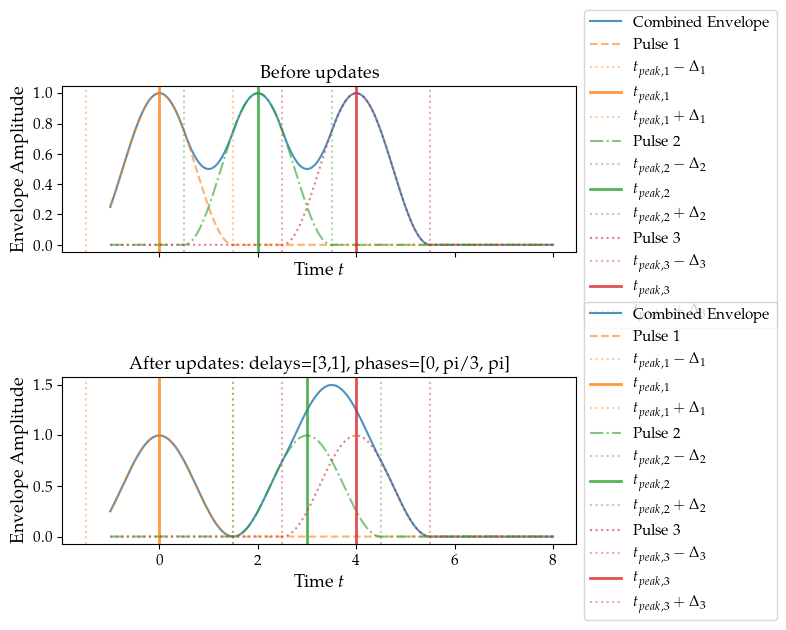

In [9]:
# Dynamic modification: phases and delays
print("Section 4: Dynamic modification of phases and delays")

# Start from a simple 3-pulse cos2 sequence with equal delays
seq_dyn = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[2.0, 2.0],
    base_amplitude=1.0,
    pulse_fwhm_fs=1.5,
    carrier_freq_cm=12000.0,
    envelope_type="cos2",
    relative_E0s=[1.0, 1.0, 1.0],
    phases=[0.0, 0.0, 0.0],
)

t_axis = np.linspace(-1.0, 8.0, 600)
fig3, (ax3a, ax3b) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plot_envelopes(t_axis, seq_dyn, ax=ax3a, label_prefix="before")
ax3a.set_title("Before updates")

# Update: change delays and phases dynamically
seq_dyn.pulse_delays = [3.0, 1.0]          # setter should recompute peak times
seq_dyn.pulse_phases = [0.0, np.pi/3, np.pi]
plot_envelopes(t_axis, seq_dyn, ax=ax3b, label_prefix="after")
ax3b.set_title("After updates: delays=[3,1], phases=[0, pi/3, pi]")
fig3.tight_layout()
print("✓ Dynamic updates applied")